## Undercatch Correction ##

Implement undercatch corrections to station data


In [2]:
#!/usr/bin/env python3
import os
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_undercatch_correction(input_nc_paths, output_nc_paths, tol=1e-6, threshold=0.99):
    """
    Calculate the undercatch correction factor for each station and time step
    in each input NetCDF file and save the filtered dataset.
    
    The catch efficiency is defined as:
        catch_efficiency = original_prcp / prcp
    where values are set to nan when prcp is zero or the ratio exceeds threshold.
    Stations with no variability (i.e. variation < tol) are dropped.
    
    Parameters
    ----------
    input_nc_paths : list of str
        List of paths to the input NetCDF files.
    output_nc_paths : list of str
        List of paths where the corrected datasets will be saved.
    tol : float, optional
        Tolerance to decide if catch efficiency values are constant (default: 1e-6).
    threshold : float, optional
        Any catch efficiency value above this threshold will be set to nan.
    """
    for input_path, output_path in zip(input_nc_paths, output_nc_paths):
        ds = xr.open_dataset(input_path)
        with np.errstate(divide='ignore', invalid='ignore'):
            raw_correction = ds["original_prcp"] / ds["prcp"]
        correction = xr.where(ds["original_prcp"] == 0, np.nan, raw_correction)
        correction = xr.where(correction > threshold, np.nan, correction)
        ds = ds.assign(catch_efficiency=correction)
        
        # Determine which stations to keep (drop stations with no variability)
        cf = ds["catch_efficiency"]
        keep_stations = []
        for i in range(cf.sizes["stn"]):
            series = cf.isel(stn=i).values
            valid = series[~np.isnan(series)]
            keep_stations.append(valid.size != 0 and np.ptp(valid) >= tol)
        keep_stations = np.array(keep_stations)
        ds_filtered = ds.isel(stn=np.where(keep_stations)[0])
        
        # Fix for stnid serialization error
        if "stnid" in ds_filtered:
            ds_filtered["stnid"].data = ds_filtered["stnid"].data.astype("S")
        
        ds_filtered.to_netcdf(output_path)
        print(f"Saved corrected dataset with {ds_filtered.sizes['stn']} stations to:\n  {output_path}")

def read_station_id_list(csv_file, column_name):
    """
    Read a CSV file and return a list of station IDs from the specified column.
    
    Parameters
    ----------
    csv_file : str
        Path to the CSV file.
    column_name : str
        Column name containing station IDs.
        
    Returns
    -------
    list
        List of station IDs.
    """
    df = pd.read_csv(csv_file)
    return df[column_name].tolist()

def plot_combined_catch_efficiency(nc_paths, csv_file_paths, station_names,
                                   output_plot_path, method_labels_netcdf=None, method_labels_csv=None):
    """
    Create a combined figure with two subplots:
    
    - Left Subplot: Comparative boxplot of catch efficiency by month
      from two NetCDF datasets.
    - Right Subplot: Aggregated boxplot of catch efficiency from CSV data
      across multiple stations.
    
    Parameters
    ----------
    nc_paths : list of str
        List of two NetCDF file paths (with a "catch_efficiency" variable).
    csv_file_paths : list of str
        List of CSV file paths (one per station) containing CE data.
    station_names : list of str
        List of station names corresponding to the CSV files.
    output_plot_path : str
        File path to save the combined plot.
    method_labels_netcdf : dict, optional
        Mapping from internal method names (e.g., "method_1") to display labels for NetCDF data.
    method_labels_csv : dict, optional
        Mapping from CSV CE column names to display labels for the aggregated plot.
    """
    # --- NetCDF Data: Prepare boxplot data ---
    dfs = []
    for i, input_path in enumerate(nc_paths):
        ds = xr.open_dataset(input_path)
        # Rename time dimension and stack station and time for plotting
        cf_da = ds["catch_efficiency"].rename({"time": "time_val"})
        cf_flat = cf_da.stack(points=("stn", "time_val"))
        df = cf_flat.to_series().rename("catch_efficiency").reset_index()
        df["time"] = pd.to_datetime(df["time_val"])
        df["month"] = df["time"].dt.month
        df["method"] = f"method_{i+1}"
        dfs.append(df)
    netcdf_df = pd.concat(dfs, ignore_index=True)
    if method_labels_netcdf:
        netcdf_df["method"] = netcdf_df["method"].map(method_labels_netcdf)
    
    # --- CSV Data: Prepare aggregated boxplot data ---
    aggregated_data = []
    for file_path, station in zip(csv_file_paths, station_names):
        data = pd.read_csv(file_path)
        data['date'] = pd.to_datetime(data['date'])
        data['month'] = data['date'].dt.month
        data['station'] = station
        aggregated_data.append(data)
    all_data = pd.concat(aggregated_data, ignore_index=True)
    
    # Reshape data so each catch efficiency method is in one column
    melted_data = pd.melt(
        all_data,
        id_vars=['month', 'station'],
        value_vars=['CE', 'CE_eccc_reanalysis', 'CE_sc_earth', 'CE_sc_reanalysis'],
        var_name='method',
        value_name='CE_calc'
    )
    # Exclude flag values (if CE_calc == 1)
    melted_data = melted_data[melted_data['CE_calc'] != 1]
    if method_labels_csv:
        melted_data['method'] = melted_data['method'].map(method_labels_csv)
    
    # --- Create the combined figure with subplots ---
    fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    
    # Left subplot: NetCDF-based catch efficiency boxplot
    sns.boxplot(ax=axs[0], x="month", y="CE_calc", hue="method", data=melted_data, palette="Set1")
    axs[0].set_title("a)")
    axs[0].xaxis.label.set_visible(False)
    
    axs[0].set_ylabel("Catch Efficiency", fontsize=12)
    axs[0].set_ylim(0, 1)
    axs[0].grid(True)
    axs[0].legend(title="Data Source", fontsize=10, title_fontsize=12)
    
    # Right subplot: Aggregated CSV catch efficiency boxplot
    sns.boxplot(ax=axs[1], x="month", y="catch_efficiency", hue="method", data=netcdf_df,palette="viridis")
    axs[1].set_title("b)")
    axs[1].set_xlabel("Month", fontsize=12)
    axs[1].set_ylabel("Catch Efficiency", fontsize=12)
    axs[1].set_ylim(0, 1)
    axs[1].grid(True)
    axs[1].legend(title="Data Source", fontsize=10, title_fontsize=12)
    
    plt.tight_layout()
    plt.savefig(output_plot_path)
    plt.close()
    print(f"Saved combined catch efficiency plot to:\n  {output_plot_path}")

def main():
    # --- File paths for NetCDF data ---
    input_nc1 = "/Users/dcasson/Data/gpep/chena/data_prep/stations/gpep_input_stations.nc"
    input_nc2 = "/Users/dcasson/Data/gpep/tuolumne/data_prep/stations/gpep_input_stations.nc"
    output_nc1 = "/Users/dcasson/Data/gpep/chena/data_prep/stations/ce_calculation.nc"
    output_nc2 = "/Users/dcasson/Data/gpep/tuolumne/data_prep/stations/ce_calculation.nc"
    os.makedirs(os.path.dirname(output_nc1), exist_ok=True)
    
    # Compute the correction factors and save the corrected datasets
    calculate_undercatch_correction(
        input_nc_paths=[input_nc1, input_nc2],
        output_nc_paths=[output_nc1, output_nc2],
        threshold=0.999
    )
    
    # --- Method labels for NetCDF boxplot ---
    method_labels_netcdf = {
        "method_1": "Chena - SC Earth with ERA5 Wind",
        "method_2": "Tuolumne - SC Earth with ERA5 Wind"
    }
    
    # --- File paths for CSV data ---
    evaluation_stations_csv = "/Users/dcasson/Data/pems/undercatch/output/evaluation_stations.csv"
    station_name_list = read_station_id_list(evaluation_stations_csv, 'Name')
    # Remove any spaces from station names (if needed)
    station_name_list = [s.replace(' ', '') for s in station_name_list]
    
    # Assume CSV files for each station are stored in a merged stations folder
    merged_station_path = Path("/Users/dcasson/Data/pems/undercatch/output/merged_stations")
    csv_file_paths = [str(merged_station_path / f"{station}.csv") for station in station_name_list]
    
    # --- Method labels for CSV aggregated plot ---
    method_labels_csv = {
        'CE': 'Bow - ECCC Station Analysis',
        'CE_eccc_reanalysis': 'Bow - ECCC Using ERA5 Wind',
        'CE_sc_earth': 'Bow - SC-Earth Station Analysis',
        'CE_sc_reanalysis': 'Bow - SC-Earth Using ERA5 Wind'
    }
    
    # --- Output path for the combined plot ---
    output_plot = "/Users/dcasson/GitHub/PEMS/images/combined_ce_plot.png"
    os.makedirs(os.path.dirname(output_plot), exist_ok=True)
    
    # Create and save the combined plot with two subplots
    plot_combined_catch_efficiency(
        nc_paths=[output_nc1, output_nc2],
        csv_file_paths=csv_file_paths,
        station_names=station_name_list,
        output_plot_path=output_plot,
        method_labels_netcdf=method_labels_netcdf,
        method_labels_csv=method_labels_csv
    )

if __name__ == "__main__":
    main()

Saved corrected dataset with 43 stations to:
  /Users/dcasson/Data/gpep/chena/data_prep/stations/ce_calculation.nc
Saved corrected dataset with 79 stations to:
  /Users/dcasson/Data/gpep/tuolumne/data_prep/stations/ce_calculation.nc
Saved combined catch efficiency plot to:
  /Users/dcasson/GitHub/PEMS/images/combined_ce_plot.png


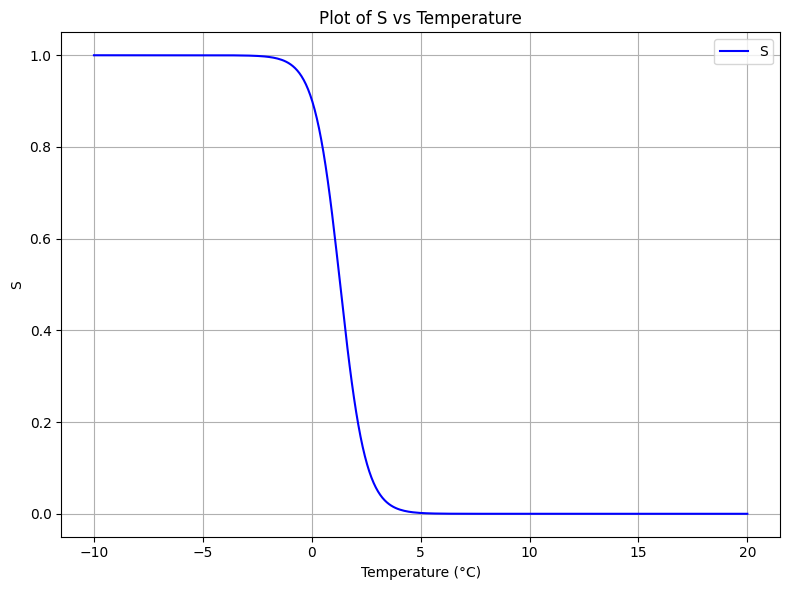

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_s(temperature, a0=2.2347, a1=-1.7108):
    """
    Calculate S based on temperature and coefficients a0 and a1.
    
    Parameters:
    - temperature: float or array, the current ensemble member mean daily 2 m air temperature
    - a0: float, fitted coefficient (default is 2.2347)
    - a1: float, fitted coefficient (default is -1.7108)
    
    Returns:
    - S: float or array, calculated value of S
    """
    S = 1 - (1 / (1 + np.exp(a0 + a1 * temperature)))
    return S

# Generate a range of temperatures from -10 to 20°C
temperatures = np.linspace(-10, 20, 300)  # 300 points between -10 and 20
S_values = calculate_s(temperatures)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(temperatures, S_values, label="S", color="blue")
plt.xlabel("Temperature (°C)")
plt.ylabel("S")
plt.title("Plot of S vs Temperature")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()